In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from torch import nn, optim

from nnbma.networks import DenselyConnected, PolynomialNetwork, FullyConnected
from nnbma.dataset import RegressionDataset, MaskDataset
from nnbma.learning import learning_procedure, LearningParameters, MaskedMSELoss, LinearBatchScheduler, BatchScheduler

from nnbma.layers import PolynomialExpansion


In [2]:

def error_factor (y_hat: np.ndarray, y: np.ndarray) :
     ef_vector=np.exp(np.log(10)*np.abs(y_hat - y))
     return (np.percentile(ef_vector,99),np.mean(ef_vector))

def metric(y_hat: np.ndarray, y: np.ndarray):
    return np.mean((y_hat - y) ** 2)


In [3]:
output_root = "../data/models"
data_dir = "../data/"

In [4]:
df_dataset = pd.read_csv("../data/dataset_train_test.csv", index_col=0)

idx = np.arange(len(df_dataset))
train_frac = 0.7
idx_max_train = int(0.7 * len(df_dataset))

df_train = df_dataset.iloc[:idx_max_train, :] * 1
df_test = df_dataset.iloc[idx_max_train:, :] * 1

X_train = np.log10(df_train.iloc[:, :3].values)
Y_train = np.log10(df_train.iloc[:, 3:].values)
X_test = np.log10(df_test.iloc[:, :3].values)
Y_test = np.log10(df_test.iloc[:, 3:].values)

X_labels = list(df_train.columns)[:3]
Y_labels = list(df_train.columns)[3:]

X_labels, Y_labels

(['x1', 'x2', 'x3'], ['co_v0_j1__v0_j0', 'co_v0_j2__v0_j1', 'co_v0_j3__v0_j2'])

In [5]:
L = 3

In [6]:
Y_train

array([[-0.04590535, -0.04590535, -0.04590535],
       [-0.20021109, -0.20021109, -0.20021109],
       [-0.34454826, -0.34454826, -0.34454826],
       ...,
       [ 0.36876645,  0.36876645,  0.36876645],
       [ 0.14163278,  0.14163278,  0.14163278],
       [-0.05378991, -0.05378991, -0.05378991]])

In [7]:
#%%  Normalisation des données entre 0 et 1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


train_dataset = RegressionDataset(X_train, Y_train)
test_dataset = RegressionDataset(X_test, Y_test)
print(f"Number of training entries: {X_train.shape[0]:,}") # 154
print(f"Number of testing entries: {X_test.shape[0]:,}") #20 #49

#%%  Procedure for training

n_layers = 4
growing_factor = 0.5

activation = nn.GELU()

Number of training entries: 1,433
Number of testing entries: 615


In [8]:
# -------------Expansion Polynomiale
order = 3  #pas + sinon surentraine
n_features = 3

n_poly = PolynomialExpansion.expanded_features(order,n_features)
#Création d'une premiere couche qui fait passer de 2 à n params par expansion polynomiale
subnet = DenselyConnected(n_poly, L, n_layers, growing_factor, activation, outputs_names=Y_labels)

#Création du réseau en prenant le subnet en premiere ligne
net = PolynomialNetwork(
    n_features,
    order,
    subnet,
    inputs_names=X_labels,
    outputs_names=Y_labels
)

net.poly.update_standardization(x=train_dataset.x, reset=True)

In [9]:
net

PolynomialNetwork(
  (poly): PolynomialExpansion()
  (subnetwork): DenselyConnected(
    (activation): GELU(approximate='none')
    (layers): ModuleList(
      (0): Linear(in_features=19, out_features=10, bias=True)
      (1): Linear(in_features=29, out_features=15, bias=True)
      (2): Linear(in_features=44, out_features=22, bias=True)
    )
    (output_layer): RestrictableLinear(in_features=66, out_features=3, bias=True)
  )
)

In [10]:
net.count_parameters()

3115

In [11]:
epochs = 1000
batch_size = len(df_train)

loss = nn.MSELoss()
learning_rate = 1e-2
optimizer = optim.AdamW(net.parameters(), learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=20, factor=0.9
)

learning_params = LearningParameters(
    loss, epochs, batch_size, optimizer, scheduler
)

results = learning_procedure(
    net,
    (train_dataset, test_dataset),
    learning_params,
    val_frac=None,
)



#%% Partie Résultats
print(f"Error Factor over training set: {error_factor(net(X_train), Y_train)}")
print(f"Error Factor over testing set: {error_factor(net(X_test), Y_test)}")

print(f"Loss over training set: {metric(net(X_train), Y_train):.2e}")
print(f"Loss over testing set: {metric(net(X_test), Y_test):.2e}")


Epoch: 100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]



Error Factor over training set: (1.0057676702299558, 1.001351548185243)
Error Factor over testing set: (1.0088265212808138, 1.001570483960747)
Loss over training set: 6.26e-07
Loss over testing set: 1.17e-06


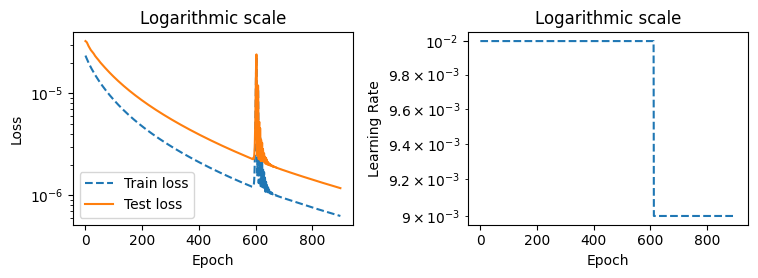

In [12]:
plt.figure(figsize=(1.2 * 6.4, 0.6 * 4.8))


plt.subplot(1, 2, 1)
plt.semilogy(results["train_loss"][100:],"--",label="Train loss")
plt.semilogy(results["val_loss"][100:], label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Logarithmic scale")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(results["lr"][100:],"--")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Logarithmic scale")

plt.tight_layout()
plt.show()


In [14]:
name="model"
net.save(name, output_root)

import pickle
with open(f"{output_root}/{name}/scaler.pickle", 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)